# Prediction of number of infractions using 1D CNNs

In [2]:
# Import Libraries
from math import floor

import pandas as pd
import seaborn as sns
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential
from matplotlib import pyplot
from numpy import mean, std
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
from sklearn.metrics import mean_squared_error
import geopandas as gpd

## Tickets dataset

In [3]:
# O ficheiro é demasiado grande para o github
df = pd.read_csv('/home/fabio/Downloads/parking-tickets-2017-2019_WDL.csv', sep=';', index_col=0,
                 parse_dates=['EntryDate'])
df

/home/fabio/miniconda3/envs/WDL/lib/python3.8/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,Block,Street,EntryDate,Bylaw,Section,Status,InfractionText,Year,HBLOCK
0,1400,Kingsway,2017-08-23,2849,17.1,IS,STOP AT A PLACE WHERE A TRAFFIC SIGN PROHIBITS...,2017,1400 KINGSWAY
1,2100,13th Ave E.,2017-08-26,2849,19.1(H),IS,STOP ON EITHER SIDE OF A LANE WHICH ABUTS COMM...,2017,2100 13TH AVE E
2,2800,Trinity St.,2017-08-26,2849,17.6(B),VA,PARK ON A STREET WHERE A TRAFFIC SIGN RESTRICT...,2017,2800 TRINITY ST
3,200,17th Ave W.,2017-08-27,2849,17.5(B),IS,STOP WITHIN 6 METRES OF THE NEAREST EDGE OF TH...,2017,200 17TH AVE W
4,1900,4th Ave W.,2017-08-19,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1900 4TH AVE W
...,...,...,...,...,...,...,...,...,...
1318730,1000,Smithe St.,2017-04-23,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1000 SMITHE ST
1318731,2500,Yew St.,2017-04-24,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,2500 YEW ST
1318732,600,Seymour St.,2017-04-20,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,600 SEYMOUR ST
1318733,1300,Robson St.,2017-04-22,2952,5(4)(a)(ii),IS,PARK IN A METERED SPACE IF THE PARKING METER H...,2017,1300 ROBSON ST


## Geodata dataset

In [4]:
streets_df = gpd.read_file('public-streets.geojson')
streets_df.head(10)

,streetuse,hblock,geometry
0,Residential,2300 E 11TH AV,"LINESTRING (-123.05819 49.26038, -123.05743 49..."
1,Residential,5500-5600 INVERNESS ST,"LINESTRING (-123.07978 49.23318, -123.07980 49..."
2,Residential,700 DURWARD AV,"LINESTRING (-123.08965 49.24086, -123.08795 49..."
3,Residential,300 DUNLEVY AV,"LINESTRING (-123.09534 49.28221, -123.09536 49..."
4,Residential,300 GORE AV,"LINESTRING (-123.09754 49.28179, -123.09747 49..."
5,Arterial,300 E HASTINGS ST,"LINESTRING (-123.09747 49.28129, -123.09538 49..."
6,Residential,300 SALSBURY DRIVE,"LINESTRING (-123.06826 49.28171, -123.06826 49..."
7,Residential,400 HAWKS AV,"LINESTRING (-123.08716 49.28110, -123.08718 49..."
8,Arterial,800 CORDOVA DIVERSION,"LINESTRING (-123.08561 49.28248, -123.08558 49..."
9,Arterial,1100 POWELL ST,"LINESTRING (-123.08125 49.28265, -123.08000 49..."


In [5]:
#convert geometry to array of coordinates
def linestring_to_points(coords_wkt):
    if coords_wkt == None:
        return None
    coords_list = []
    if coords_wkt.geom_type == "LineString":
        coords = coords_wkt.coords
        for c in coords:
            #print(c[1])
            coords_list.append([c[1],c[0]])
    elif coords_wkt.geom_type == "MultiLineString":
        for geometry in coords_wkt:
            coords = geometry.coords
            for c in coords:
                #print(c[1])
                coords_list.append([c[1],c[0]])
    return coords_list

streets_df['coordinates'] = streets_df.apply(lambda row : linestring_to_points(row.geometry), axis=1)
streets_df.tail(10)

,streetuse,hblock,geometry,coordinates
17023,Residential,3400 E 45TH AV,"LINESTRING (-123.02986 49.22925, -123.02917 49...","[[49.22925139945035, -123.02986291919282], [49..."
17024,Residential,3300 E 43RD AV,"LINESTRING (-123.03454 49.23086, -123.03365 49...","[[49.23085721514072, -123.03454021728], [49.23..."
17025,Residential,3500-3600 HAIDA DRIVE,"LINESTRING (-123.02526 49.25359, -123.02462 49...","[[49.25359014158789, -123.02525742785252], [49..."
17026,Secondary Arterial,1000-1100 W 16TH AV,"LINESTRING (-123.12723 49.25701, -123.12794 49...","[[49.25701357799479, -123.12722979294234], [49..."
17027,Residential,900 W 17TH AV,"LINESTRING (-123.12443 49.25619, -123.12726 49...","[[49.256188217761945, -123.12442524680777], [4..."
17028,Residential,800 W 17TH AV,"LINESTRING (-123.12376 49.25618, -123.12443 49...","[[49.256175894958695, -123.12376303059968], [4..."
17029,Residential,700 W 17TH AV,"LINESTRING (-123.12011 49.25610, -123.12078 49...","[[49.256102791152884, -123.12011491829853], [4..."
17030,Residential,800 W 20TH AV,"LINESTRING (-123.12217 49.25343, -123.12453 49...","[[49.253433539738346, -123.12216595989375], [4..."
17031,Residential,900 W 22ND AV,"LINESTRING (-123.12676 49.25171, -123.12745 49...","[[49.25171152555883, -123.12676249700912], [49..."
17032,Residential,2600 TEMPLETON DRIVE,"LINESTRING (-123.06012 49.26084, -123.06013 49...","[[49.26084417175707, -123.06011699423122], [49..."


## Holiday dataset

In [6]:
holiday_df = pd.read_csv('holidays.csv', sep=',', parse_dates=['date'])
holiday_df.head(5)

,date,holiday
0,2017-01-01,New Year's Day
1,2017-02-20,Family Day
2,2017-04-14,Good Friday
3,2017-05-22,Victoria Day
4,2017-07-03,Canada Day


## Categorical features

In [7]:
def categorical_feature_study(_df, feature, horizontal=False, treshould=0, plot=True):
    df = _df.copy()
    df = df[feature].value_counts().to_frame()

    if treshould > 0:
        df = df[df[feature] >= treshould]

    df = df.reset_index()
    df = df.rename(columns={feature: "Count"})
    df = df.rename(columns={"index": feature})

    if plot:
        fig, ax = pyplot.subplots()  # figsize=(20,15))

        if horizontal:
            sns.barplot(x="Count", y=feature, data=df, ax=ax)
        else:
            sns.barplot(x=feature, y="Count", data=df, ax=ax)

        ax.plot()

    return df

## Encode categorical features

In [8]:
enc = OrdinalEncoder()
df["InfractionText"] = enc.fit_transform(df[["InfractionText"]]).astype(int)

df_infraction = categorical_feature_study(
    df, "InfractionText", horizontal=True, treshould=10000, plot=False)
df_infraction.head()

,InfractionText,Count
0,21,649308
1,37,144750
2,28,106396
3,30,70446
4,91,42980


In [9]:
enc = OrdinalEncoder()
df["Street"] = enc.fit_transform(df[["Street"]]).astype(int)

df_streets = categorical_feature_study(
    df, "Street", horizontal=True, treshould=10000, plot=False)
df_streets.head()

,Street,Count
0,1688,43603
1,1654,31322
2,806,29818
3,1343,28612
4,1348,28438


## Number of infractions per day

,Count
count,1089.000000
mean,1210.959596
std,262.500196
min,1.000000
10%,846.200000
20%,970.600000
30%,1075.400000
40%,1160.200000
50%,1241.000000
60%,1309.800000


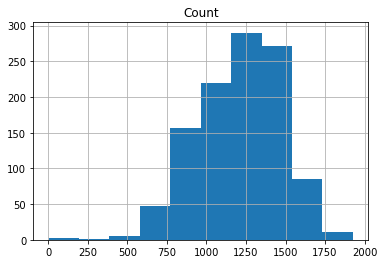

In [10]:
nInfractionsPerDay = df.groupby(['EntryDate']) \
    .count() \
    .rename(columns={'Block': 'Count'})[['Count']] \
    .reset_index()
nInfractionsPerDay["dayOfWeek"] = nInfractionsPerDay.apply(
    lambda row: row.EntryDate.weekday(), axis=1)
nInfractionsPerDay = pd.merge(nInfractionsPerDay, holiday_df, how='left', left_on='EntryDate',
                              right_on='date').drop(columns=['date']).fillna(0, downcast='infer')
nInfractionsPerDay["holiday"] = nInfractionsPerDay.apply(
    lambda row: 0 if row.holiday == 0 else 1, axis=1)

h = nInfractionsPerDay[["Count"]].hist()

nInfractionsPerDay[["Count"]].describe([.1, .2, .3, .4, .5, .6, .7, .8, .9])

## Mapping to categories

- 1 -> Low/No infractions
- 2 -> Some infractions
- 3 -> Average number of infractions
- 4 -> Large number of infractions
- 5 -> Lots of infractions

In [11]:
mapping_dic = {
    1: [0, 970.6],
    2: [970.6, 1160.2],
    3: [1160.2, 1309.8],
    4: [1309.8, 1448.4],
    5: [1448.4, -1]
}


def map_to_cat(num):
    for key, ranges in mapping_dic.items():
        if num >= ranges[0] and (ranges[1] == -1 or num < ranges[1]):
            return key

    print("Negative values not allowed")
    return -1


dfCat = nInfractionsPerDay.copy()
#dfCat["countCat"] = dfCat.apply(lambda row: map_to_cat(row.Count), axis=1)

#del dfCat["Count"]
dfCat

,EntryDate,Count,dayOfWeek,holiday
0,2017-01-02,870,0,0
1,2017-01-03,1487,1,0
2,2017-01-04,1341,2,0
3,2017-01-05,1358,3,0
4,2017-01-06,1413,4,0
...,...,...,...,...
1084,2019-12-27,1155,4,0
1085,2019-12-28,1015,5,0
1086,2019-12-29,903,6,0
1087,2019-12-30,1083,0,0


In [12]:
df_parking_holidays = pd.merge(df,holiday_df, how='left', left_on='EntryDate', right_on='date').drop(columns= ['date'])

f_parking_holidays_count_street_and_day = df_parking_holidays\
    .groupby(['InfractionText', 'EntryDate', 'holiday'], dropna=False, as_index=False)['Street'] \
    .count().rename(columns={'Street':'infraction_count'})

df_parking_holidays_count_by_street_and_day = df_parking_holidays \
    .groupby(['Street','EntryDate', 'holiday', 'HBLOCK'], dropna=False, as_index=False)['InfractionText'] \
    .count() \
    .rename(columns={'InfractionText':'infraction_count'})

df_street_mean_count = pd.merge(left=df_parking_holidays_count_by_street_and_day, \
                right=streets_df[['hblock', 'coordinates']],\
                how='left', left_on='HBLOCK', right_on='hblock').drop(columns= ['hblock'])

df_street_mean_count['coordinates'] = [ [] if x is np.NaN else x for x in df_street_mean_count['coordinates']]

df_street_mean_count['mean_point_lat'] = df_street_mean_count.apply(lambda x: (x['coordinates'][0][0] + x['coordinates'][-1][0])/2 if len(x['coordinates']) > 0 else None , axis=1)
df_street_mean_count['mean_point_long'] = df_street_mean_count.apply(lambda x: (x['coordinates'][0][1] + x['coordinates'][-1][1])/2 if len(x['coordinates']) > 0 else None , axis=1)

df_street_mean_count.dropna(axis=0, how='any', inplace = True)

df_street_mean_count=df_street_mean_count[["EntryDate", "mean_point_lat", "mean_point_long", "infraction_count"]]

df_street_mean_count=df_street_mean_count.reset_index()

In [13]:
df_street_mean_count

,index,EntryDate,mean_point_lat,mean_point_long,infraction_count
0,44845,2017-12-24,49.280150,-123.107616,1
1,44846,2017-12-24,49.280835,-123.107594,1
2,45261,2018-02-19,49.282232,-123.107092,1
3,45262,2018-02-19,49.282701,-123.106889,1
4,45263,2018-02-19,49.281309,-123.107474,2
...,...,...,...,...,...
11137,832568,2017-10-09,49.264595,-123.112837,1
11138,832569,2017-10-09,49.263690,-123.112878,1
11139,832570,2017-10-09,49.263323,-123.112894,1
11140,832749,2017-11-11,49.267307,-123.112717,2


In [14]:
def generate_features(df, cols, distance=1, count_before=3):
    # Filter rows in which we cannot trace back history
    periodDf = df[df.index-(count_before*distance)>=0].copy()
    # Number of removed elements is the offset for the new df
    n_removed=df.shape[0]-periodDf.shape[0]
    # Add new features based on traced history
    for col in cols:
        for i in range(0, count_before):
            diff=(i+1)*distance
            periodDf[col+"_minus_" + str(diff)]=periodDf.apply(lambda row: df.iloc[int(row.name)-diff][col], axis=1) 
        
    return periodDf

dfFeatures=generate_features(df_street_mean_count, ["infraction_count"], distance=7, count_before=4)
dfFeatures=dfFeatures.reset_index()

In [15]:
dfFeatures

,level_0,index,EntryDate,mean_point_lat,mean_point_long,infraction_count,infraction_count_minus_7,infraction_count_minus_14,infraction_count_minus_21,infraction_count_minus_28
0,28,46278,2018-07-02,49.282232,-123.107092,1,4,3,4,1
1,29,46279,2018-07-02,49.282701,-123.106889,1,4,3,2,1
2,30,46280,2018-07-02,49.281309,-123.107474,1,3,14,5,1
3,31,46281,2018-07-02,49.281766,-123.107286,1,3,14,6,1
4,32,46282,2018-07-02,49.280150,-123.107616,3,2,3,6,2
...,...,...,...,...,...,...,...,...,...,...
11109,11137,832568,2017-10-09,49.264595,-123.112837,1,1,1,1,1
11110,11138,832569,2017-10-09,49.263690,-123.112878,1,1,2,1,3
11111,11139,832570,2017-10-09,49.263323,-123.112894,1,2,2,1,3
11112,11140,832749,2017-11-11,49.267307,-123.112717,2,2,1,1,1


In [17]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale

projectedDf=dfFeatures[["mean_point_lat", "mean_point_long",  *dfFeatures.columns[6:]]]

scaler = MinMaxScaler()
scaler.fit(projectedDf)
projectedDf[['mean_point_lat', 'mean_point_long', *dfFeatures.columns[6:]]]  = scaler.transform(projectedDf)


projectedDf=pd.concat([dfFeatures[["EntryDate", "infraction_count"]], projectedDf], axis=1)
projectedDf

<ipython-input-17-1726ff6c402b>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  projectedDf[['mean_point_lat', 'mean_point_long', *dfFeatures.columns[6:]]]  = scaler.transform(projectedDf)
/home/fabio/miniconda3/envs/WDL/lib/python3.8/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,EntryDate,infraction_count,mean_point_lat,mean_point_long,infraction_count_minus_7,infraction_count_minus_14,infraction_count_minus_21,infraction_count_minus_28
0,2018-07-02,1,0.869903,0.565020,0.136364,0.090909,0.136364,0.000000
1,2018-07-02,1,0.875133,0.566085,0.136364,0.090909,0.045455,0.000000
2,2018-07-02,1,0.859632,0.563020,0.090909,0.590909,0.181818,0.000000
3,2018-07-02,1,0.864715,0.564008,0.090909,0.590909,0.227273,0.000000
4,2018-07-02,3,0.846719,0.562281,0.045455,0.090909,0.227273,0.045455
...,...,...,...,...,...,...,...,...
11109,2017-10-09,1,0.673482,0.534949,0.000000,0.000000,0.000000,0.000000
11110,2017-10-09,1,0.663411,0.534739,0.000000,0.045455,0.000000,0.090909
11111,2017-10-09,1,0.659321,0.534655,0.045455,0.045455,0.000000,0.090909
11112,2017-11-11,2,0.703694,0.535581,0.045455,0.000000,0.000000,0.000000


## Prediction model

### Objective
#### Predict the number of infractions based on previous 4 weeks of data (on the same week day)

### Model parameters
#### Last 4 days of the same day of the week
#### Latitude and longitude of mean road/block segments of the previous 4 days of the same day of the week 
e.g.
- Day we want to predict -> 25 of April
- X     ->  Mean Latitude/Longitude of road/block segment Number of infractions of days 4, 11, 18, 25 of Abril 
        
- Y     -> countCat after one week

In [23]:
from sklearn.preprocessing import OneHotEncoder

def prepare_inputs(X_train, X_test):
    ohe = OneHotEncoder()
    ohe.fit(X_train)
    X_train_enc = ohe.transform(X_train)
    X_test_enc = ohe.transform(X_test)
    return X_train_enc, X_test_enc


def split_df(df, train_size=0.8):
    train_size = floor(df.shape[0]*train_size)

    train = df[:train_size]
    test = df[train_size:]
    
    return train, test

def process_df(train, test):
    trainX = train[["mean_point_lat", "mean_point_long", *train.columns[2:]]]
    trainX = trainX.to_numpy().reshape(trainX.shape[0], trainX.shape[1], 1)
    trainY = train[["infraction_count"]]
    trainY = trainY.to_numpy().reshape(trainY.shape[0])
    testX = test[["mean_point_lat", "mean_point_long", *test.columns[2:]]]
    testX = testX.to_numpy().reshape(testX.shape[0], testX.shape[1], 1)
    testY = test[["infraction_count"]]
    testY = testY.to_numpy().reshape(testY.shape[0])
    
    
    return trainX, trainY, testX, testY

train, test = split_df(projectedDf)
trainX, trainy, testX, testy = process_df(train, test)

In [32]:
# fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    n_timesteps, n_features, n_outputs = trainX.shape[0], trainX.shape[1], trainX.shape[2]
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=6, activation='relu', input_shape=(n_features, n_outputs)))
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(1, activation='relu')) # 5 class labels -> 5 softmax neurons
    model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error'])
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return model, accuracy


def run_experiment(trainX, trainy, testX, testy, repeats=10):
    min_score=-1
    min_model=None
    # repeat experiment
    scores = list()
    for r in range(repeats):
        print("Train #{}....".format(r))
        model, score = evaluate_model(trainX, trainy, testX, testy)
        if min_score==-1 or score<min_score:
            min_score=score
            min_model=model
        scores.append(score)
    return min_model, scores

model, scores = run_experiment(trainX, trainy, testX, testy, repeats=2)

scores

Train #0....
Train #1....


[3.6415324211120605, 3.6022708415985107]

In [33]:
predict = model.predict(testX)
dfPredict=pd.DataFrame(data=predict.flatten()[:], columns=["predict"])
dfPredict

,predict
0,3.201888
1,2.746062
2,2.735113
3,2.681684
4,2.339101
...,...
2218,1.639877
2219,1.721027
2220,1.796149
2221,1.900836


In [34]:
truth=pd.DataFrame(data=testy[:], columns=["truth"])
testDf=pd.concat([dfPredict, truth, test.reset_index()[["EntryDate"]]], axis=1)
testDf

,predict,truth,EntryDate
0,3.201888,2,2019-04-19
1,2.746062,2,2019-04-19
2,2.735113,6,2019-04-19
3,2.681684,6,2019-04-19
4,2.339101,1,2019-04-19
...,...,...,...
2218,1.639877,1,2017-10-09
2219,1.721027,1,2017-10-09
2220,1.796149,1,2017-10-09
2221,1.900836,2,2017-11-11


Root mean Squared Error >> 1.897964955345707


Text(0, 0.5, 'Number of infractions')

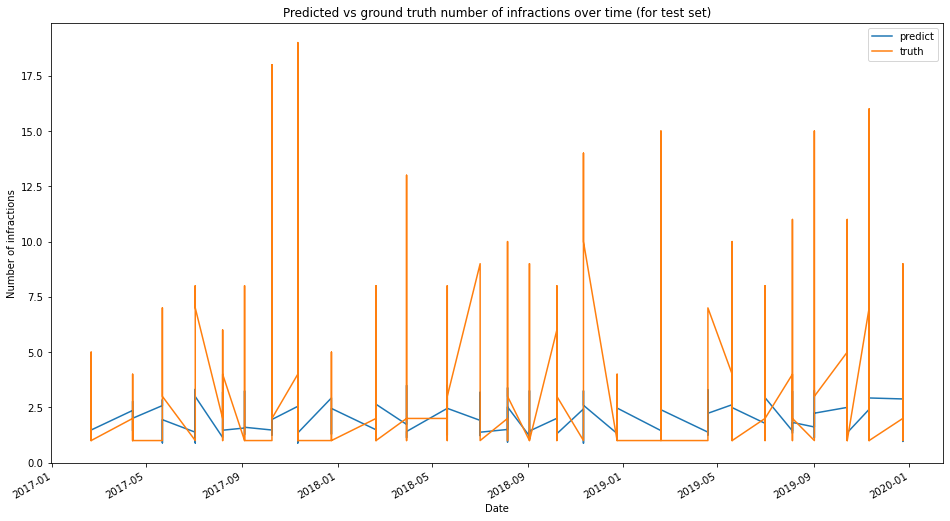

In [35]:
rms = np.sqrt(mean_squared_error(testDf["truth"], testDf["predict"]))
print ("Root mean Squared Error >> " + str(rms))
testDf.reset_index()
ax=testDf.plot(x="EntryDate", figsize=(16,9), title='Predicted vs ground truth number of infractions over time (for test set)')

ax.set_xlabel("Date")
ax.set_ylabel("Number of infractions")

In [36]:
filteredTestDf=testDf[(testDf.EntryDate>="2019-12-01") & (testDf.EntryDate<="2019-12-31")]
filteredTestDf

,predict,truth,EntryDate
53,3.012717,3,2019-12-24
54,3.079510,2,2019-12-24
55,3.039693,1,2019-12-24
56,3.307902,1,2019-12-24
57,3.231568,3,2019-12-24
...,...,...,...
1852,1.884335,2,2019-12-24
1853,1.799061,1,2019-12-24
1854,1.950770,1,2019-12-24
2086,1.623435,4,2019-12-24


In [37]:
rms = mean_squared_error(filteredTestDf["truth"], filteredTestDf["predict"])
rms

2.8248575493343235